In [2]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [ ]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

In [ ]:
url_list[:5]

In [ ]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [ ]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [ ]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

In [ ]:
code_list = [102, 103, 105]

code_list

In [ ]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [ ]:
df = make_total_data(1, code_list, 20200506)

In [ ]:
print('뉴스 기사의 개수: ',len(df))

In [ ]:
df.sample(10)

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


csv_path = "news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [2]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

0       파주시청 사진제공파주시 파주시청 사진제공파주시파주파이낸셜뉴스 강근주 기자 파주시는 ...
1       동영상 뉴스이천 물류창고 화재 발화지점으로 지목된 지하 층에서 산소절단기의 산소 공...
2       황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검 사진제...
3       귀갓길 여성을 쫓아가 성범죄를 시도한 대 남성이 구속됐습니다서울 강남경찰서는 강간상...
4       서울연합뉴스 대한약사회가 일부터 코로나바이러스 감염증 대응 체계를 사회적 거리두기에...
                              ...                        
5119    신종 코로나바이러스 감염증코로나 사태 이후 가정의 달 월에도 언택트비대면 신풍속도가...
5120    는 소비자로부터 월 이용료 만만원을 받고 초고속 인터넷을 제공한다 그런 브로드밴드가...
5121    머리를 긁고 있는 오랑우탄 몸을 긁는 행동을 따라 하는 것은 부정적 감정과 관련이 ...
5122    가 오는 일 정식 출시하는 스마트폰 벨벳이 사실상 공짜폰이 될 전망이다 단말기 가격...
5123    이미지제공게티이미지뱅크 이미지제공게티이미지뱅크  전자신문  전자신문인터넷 무단전재 ...
Name: news, Length: 5124, dtype: object

In [3]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [4]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


In [5]:
# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3994


<AxesSubplot:>

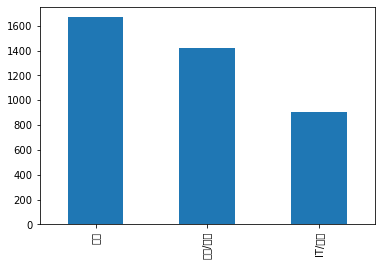

In [6]:
df['code'].value_counts().plot(kind = 'bar')

In [7]:
df['code'].value_counts()

사회       1668
생활/문화    1423
IT/과학     903
Name: code, dtype: int64

In [8]:
print(df.groupby('code').size().reset_index(name = 'count'))

code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423


In [9]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','노컷뉴스','매일신문']

In [10]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from konlpy.tag import Mecab, Komoran,Kkma,Hannanum
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data,mode):
  text_data = []
  mode = mode.lower()

  if mode == "mecab":
      tokenizer = Mecab()
  elif mode == 'komoran':
      tokenizer = Komoran()
  elif mode == 'kkma':
      tokenizer = Kkma()
  elif mode == 'hannanum':
      tokenizer = Hannanum()        

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [13]:
text_data = preprocessing(df['news'],"mecab")

In [14]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [15]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [16]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [19]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."],"mecab")
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [22]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"],"mecab")
print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [23]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."],"mecab")
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [24]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.84       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999



# Step 1. 형태소 분석기 변경해 보기

한국어 자연어 처리에 성능에 영향을 주는 또 다른 요소는 사용하는 형태소 분석기의 종류입니다. 앞서 진행한 프로젝트에서는 Mecab을 사용했었습니다. 하지만 이번에 설치한 konlpy 패키지 안에는 Mecab 이외에도 Hannanum, Kkma, Komoran, Okt 라는 형태소분석기가 존재합니다. 이들 형태소 분석기 중 어떤 것을 선택하는 것이 좋을지, 형태소 분석기간의 장단점은 무엇인지, 처리 속도와 성능에는 어떤 변화가 있는지 비교해 보세요.

In [2]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup
from konlpy.tag import Mecab, Komoran,Kkma,Hannanum
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

csv_path = "news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()


def preprocessing(data,mode):
  text_data = []
  mode = mode.lower()

  if mode == "mecab":
      tokenizer = Mecab()
  elif mode == 'komoran':
      tokenizer = Komoran()
  elif mode == 'kkma':
      tokenizer = Kkma()
  elif mode == 'hannanum':
      tokenizer = Hannanum()        

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [5]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','노컷뉴스','매일신문']

text_data1 = preprocessing(df['news'],"mecab")
text_data2 = preprocessing(df['news'],"komoran")
text_data3 = preprocessing(df['news'],"kkma")
text_data4 = preprocessing(df['news'],"hannanum")

TypeError: startJVM() got an unexpected keyword argument 'convertStrings'

In [9]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [10]:
X_train, X_test, y_train, y_test = train_test_split(text_data1, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.93      0.85      0.89       355
          사회       0.80      0.91      0.85       500
       생활/문화       0.87      0.79      0.83       426

    accuracy                           0.85      1281
   macro avg       0.87      0.85      0.86      1281
weighted avg       0.86      0.85      0.85      1281



In [11]:
X_train, X_test, y_train, y_test = train_test_split(text_data2, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

NameError: name 'text_data2' is not defined

In [12]:
X_train, X_test, y_train, y_test = train_test_split(text_data3, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

NameError: name 'text_data3' is not defined

In [13]:
X_train, X_test, y_train, y_test = train_test_split(text_data4, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

NameError: name 'text_data4' is not defined

# Step 2. 불용어 추가해 보기

머신 러닝을 하다보면 전처리는 어쩌면 끝이 없는 작업일 수도 있습니다. 불용어 추가도 마찬가지입니다. 데이터를 출력해 보고, 직접 뉴스를 열어보면서 불용어가 총 50개가 될 때까지 추가해 보세요. 그리고 불용어를 추가하기 전, 후의 모델 성능을 비교해 보세요.

지나치게 빈도가 낮은 단어, 지나치게 빈도가 높은 단어 둘 중 어떤 단어가 불용어로 선택할 경우에 모델 성능 향상에 효과가 더 좋을지도 고민해 봅시다.

In [14]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스','노컷뉴스','매일신문','그','나오','가지','씨','시키','만들','지금','생각하','그러','속','하나','집','살','모르','적','월','데','자신','안','어떤','내','경우','명','생각','시간','그녀','다시','이런','앞','보이','번','나','다른','어떻','여자','개','전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하','소리','놓','권','자','재','될','고','되','며','주','인','시','일','파','만','총','게','태','스','크','를','어','당','각','지난','관련','지만','사람','입니다','습니다','밝혔','지만','면서','지난','우리','이상','이용','경우','뉴시스','까지','다는','다면']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(text_data1, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.93      0.85      0.89       355
          사회       0.80      0.91      0.85       500
       생활/문화       0.87      0.79      0.83       426

    accuracy                           0.85      1281
   macro avg       0.87      0.85      0.86      1281
weighted avg       0.86      0.85      0.85      1281



![ex_screenshot](./image.png)

단어 빈출 정도를 파악해서 높게 나온 단어 들 중 의미를 갖지 않는다고 생각하는 단어들을 불용어에 넣어주니 accuracy가 향상되었다

In [26]:
df_1 = pd.read_table("news_data.csv", sep=',')
df_2 = pd.read_table("news_data2.csv", sep=',')
df=pd.concat([df_1,df_2],axis=0,ignore_index=True)
df.head()

,news,code
0,파주시청. 사진제공=파주시 파주시청. 사진제공=파주시\n\n[파주=파이낸셜뉴스 강근...,사회
1,동영상 뉴스\n\n이천 물류창고 화재 발화지점으로 지목된 지하 2층에서 산소절단기의...,사회
2,황범순 의정부시 부시장 을지대학교 의정부캠퍼스 및 부속병원 공사현장 안전점검. 사진...,사회
3,귀갓길 여성을 쫓아가 성범죄를 시도한 20대 남성이 구속됐습니다.서울 강남경찰서는 ...,사회
4,(서울=연합뉴스) 대한약사회가 6일부터 코로나바이러스 감염증 대응 체계를 '사회적 ...,사회


In [27]:
text_data1 = preprocessing(df['news'],"mecab")

In [28]:
X_train, X_test, y_train, y_test = train_test_split(text_data1, df['code'], random_state = 0)
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

precision    recall  f1-score   support

       IT/과학       0.77      0.89      0.82       506
          경제       0.86      0.28      0.43       247
          사회       0.78      0.91      0.84       760
       생활/문화       0.84      0.79      0.81       694

    accuracy                           0.80      2207
   macro avg       0.81      0.72      0.72      2207
weighted avg       0.80      0.80      0.78      2207



NameError: name 'labels' is not defined